In [2]:
# handle imports
import numpy as np
import random
import matplotlib.pyplot as plt
import h5py
from collections import deque
from matplotlib.colors import hsv_to_rgb
from tqdm import tqdm
from scipy.optimize import curve_fit, minimize
from scipy.stats import linregress

rng = np.random.default_rng()

In [6]:
# Some useful utility functions

def batch_estimate(data,observable,k):
    '''Devide data into k batches and apply the function observable to each.
    Returns the mean and standard error.'''
    batches = np.reshape(data,(k,-1))
    values = np.apply_along_axis(observable, 1, batches)
    return np.mean(values), np.std(values)/np.sqrt(k-1)

def jackknife_batch_estimate(data,observable,k):
    '''Devide data into k batches and apply the function observable to each 
    collection of all but one batches. Returns the mean and corrected 
    standard error.'''
    batches = np.reshape(data,(k,-1))
    values = [observable(np.delete(batches,i,0).flatten()) for i in range(k)]
    return np.mean(values), np.sqrt(k-1)*np.std(values)

In [8]:
# Useful Potts model utility functions

def initialize_lattice(L, q):
    """
    Create an LxL lattice initialized with random spin states.
    Parameters:
    """
    return rng.integers(0, q, size=(L, L))

def initialize_lattice_ordered(L):
    return np.zeros((L, L))

def calculate_critical_temperature(J, q, k_B=1.0):
    """
    Calculate the critical temperature T_C for the Potts model.
    """
    return J / (k_B * np.log(1 + np.sqrt(q)))


def plot_lattice(lattice, q, title = "", ax=None):
    normalized = lattice / q
    
    hsv_image = np.zeros((*lattice.shape, 3))
    hsv_image[..., 0] = normalized
    hsv_image[..., 1] = 1.0
    hsv_image[..., 2] = 1.0
    rgb_image = hsv_to_rgb(hsv_image)

    if ax is not None:
        ax.imshow(rgb_image, origin='upper', aspect='equal')
        ax.axis('off')
    else:
        plt.figure(figsize=(4, 4))
        plt.imshow(rgb_image, origin='upper', aspect='equal')
        plt.axis('off')
        plt.title(title)
        plt.show()

def plot_lattices(lattices, q, titles=None):
    num_lattices = len(lattices)

    fig, ax = plt.subplots(1, len(lattices), figsize=(4 * num_lattices, 4))
    
    for i, lattice in enumerate(lattices):
        plot_lattice(lattice, q, ax=ax[i])
    
    plt.tight_layout()
    plt.show()

def calculate_magnetization(lattice, q):
    """
    Calculate the magnetization for a Potts model lattice.
    """
    angles = 2 * np.pi * lattice / q
    spins = np.exp(1j * angles)
    M_vec = np.mean(spins)
    return np.abs(M_vec)

def calculate_magnetic_susceptibility(magnetizations, T):
    """
    Calculate magnetic susceptibility from magnetization samples.
    """
    mean_m2 = np.mean(np.square(magnetizations))
    mean_m = np.mean(magnetizations)
    susceptibility = (mean_m2 - mean_m**2) / T
    return susceptibility

def calculate_autocorrelation_time(lattices, observable, plot = False):
    """
    Calculate the autocorrelation time of an observable from a sequence of lattices
    """
    observables = np.array([observable(lattice) for lattice in lattices])
    mean_obs = np.mean(observables)
    fluctuations = observables - mean_obs

    N = len(observables)
    tmax = N // 2

    autocorr = np.array([
        np.dot(fluctuations[:N - lag], fluctuations[lag:]) / (N - lag) 
        for lag in range(tmax)
    ])
    autocorr /= autocorr[0]

    def exp_decay(t, tau):
        return np.exp(-t / tau)

    try:
        popt, _ = curve_fit(exp_decay, np.arange(tmax), autocorr, p0=(10,))
        tau = popt[0]
    except RuntimeError:
        tau = None

    if plot and tau is not None:
        plt.figure(figsize=(4, 4))
        plt.plot(np.arange(tmax), autocorr, label="Autocorrelation")
        plt.plot(np.arange(tmax), exp_decay(np.arange(tmax), tau), label="Fit", linestyle="--")
        plt.legend()
        plt.title("Autocorrelation")
        plt.show()

    return tau

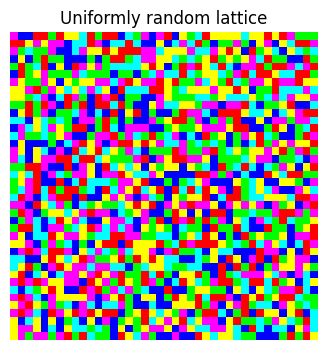

performed 50 sweeps (30472 steps) of the Wolff cluster flip algorithm


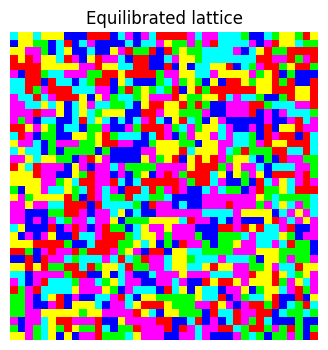

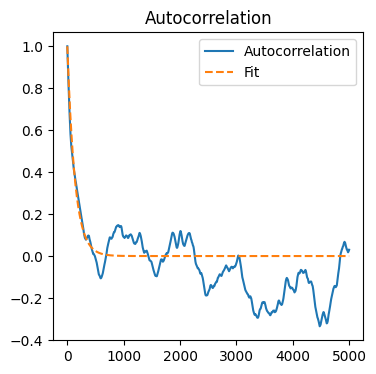

Found an autocorrelation time of 134.17686293935142 steps


In [4]:
# Example for how to use some of the utility functions
L = 40
q = 6
T = 1.2
J = 1.0
lattice = initialize_lattice(L, q)
plot_lattice(lattice, q, "Uniformly random lattice")
steps = 0
for _ in range(50):
    steps += wolff_sweep(lattice, T, J, q)
print(f"performed 50 sweeps ({steps} steps) of the Wolff cluster flip algorithm")
plot_lattice(lattice, q, "Equilibrated lattice")

lattices = []
for _ in range(10000):
    lattices.append(np.copy(lattice))
    wolff_step(lattice, T, J, q)

tau = calculate_autocorrelation_time(lattices, lambda lattice: calculate_magnetization(lattice, q), plot=True)
print(f"Found an autocorrelation time of {tau} steps")

In [4]:
# define the equilibration time using the sum of the equilibration times of 3 trial runs
def equilibration_time(L, T, q, J, plot=False):
    if plot:
        plt.figure(figsize=(6, 4))
        plt.xlabel("Sweep", fontsize=14)
        plt.ylabel("Magnetization (M)", fontsize=14)
        plt.title("Magnetization as function of number of sweeps", fontsize=16)
    
    sweep_counts = 0
    for run in range(3):
        ordered_lattice = initialize_lattice_ordered(L)
        disordered_lattice = initialize_lattice(L, q)

        sweeps = [0]
        mags_ordered = [calculate_magnetization(ordered_lattice, q)]
        mags_disordered = [calculate_magnetization(disordered_lattice, q)]
        i = 0
        while mags_ordered[i] > mags_disordered[i]:
            i += 1
            wolff_sweep(ordered_lattice, T, J, q)
            wolff_sweep(disordered_lattice, T, J, q)
            sweeps.append(i)
            mags_ordered.append(calculate_magnetization(ordered_lattice, q))
            mags_disordered.append(calculate_magnetization(disordered_lattice, q))
        if plot:
            plt.plot(sweeps, mags_ordered, label=f"Ordered lattice, run {run+1}")
            plt.plot(sweeps, mags_disordered, label=f"Disordered lattice, run {run+1}")

        sweep_counts += i
    if plot:
        plt.legend()
        plt.grid(True)
        plt.show()

    return sweep_counts

#L = 40
J = 1.0
#q = 4
#T = calculate_critical_temperature(J, q)
#equil_sweeps = equilibration_time(L, T, q, J, plot=True)
print(f"Conservative equilibration time: {equil_sweeps}")

NameError: name 'equil_sweeps' is not defined

In [6]:
def autocorrelation_times(temperatures, equil_sweeps, L, q, J, samples=3000):
    autocorrelation_times = []
    for T in temperatures:
        lattice = initialize_lattice(L, q)
        
        for _ in range(equil_sweeps):
            wolff_sweep(lattice, T, J, q)

        lattices = []
        flipped = 0
        for i in range(samples):
            lattices.append(np.copy(lattice))
            flipped += wolff_step(lattice, T, J, q)

        tau_steps = calculate_autocorrelation_time(lattices, lambda lattice: calculate_magnetization(lattice, q))
        tau_sweeps = tau_steps * flipped / samples / (L * L)
        autocorrelation_times.append(tau_sweeps)
    return autocorrelation_times        

In [7]:
def create_potts_measurements(temperatures, equil_sweeps, sample_sweeps, L, q, J, samples=100):
    """
    Simulate the Potts model. Returns samples of the magnetization for each temperature.
    """
    magnetizations = []
    for T in tqdm(temperatures):
        lattice = initialize_lattice(L, q)

        for _ in range(equil_sweeps):
            wolff_sweep(lattice, T, J, q)

        magnetizations_t = np.zeros(samples)
        for i in range(samples):
            magnetizations_t[i] = calculate_magnetization(lattice, q)
            
            for _ in range(sample_sweeps):
                wolff_sweep(lattice, T, J, q)

        magnetizations.append(magnetizations_t)

    return magnetizations

qs = [2,3,4,5,6]
Ls = [10,20,30,40,50,60,70,80]
J = 1.0

with h5py.File('full_measurements.hdf5','a') as f:
    if not "equilibration_times" in f:
        equil_times = np.zeros((len(Ls), len(qs)))
        for index_L, L in tqdm(enumerate(Ls)):
            for index_q, q in enumerate(qs):
                T_C = calculate_critical_temperature(J, q)
                equil_time = equilibration_time(L,T_C,q,J)
                equil_times[index_L, index_q] = equil_time
        f.create_dataset(f"equilibration_times",data=equil_times)

    print("Calculated equilibration times")
    equil_times = f["equilibration_times"][()]
    
    if not "autocorrelation_times" in f:
        autocorr_times = np.zeros((len(Ls), len(qs)))
        for index_L, L in tqdm(enumerate(Ls)):
            for index_q, q in enumerate(qs):
                T_C = calculate_critical_temperature(J, q)
                measure_temps = np.linspace(0.7 * T_C, 1.3 * T_C, 50)
                equil_time = int(equil_times[index_L,index_q])
                autocorr = autocorrelation_times(measure_temps, equil_time, L, q, J, samples=3000)
                autocorr_times[index_L, index_q] = np.max(autocorr)
        f.create_dataset(f"autocorrelation_times",data=autocorr_times)

    print("Calculated autocorrelation times")
    autocorr_times = f["autocorrelation_times"][()]
    thinning = np.maximum(np.ones_like(autocorr_times), np.rint(autocorr_times))

    temps_per_q = 81
    if not "temperatures" in f:
        temperatures = np.zeros((len(qs), temps_per_q))
        for index_q, q in enumerate(qs):
            T_C = calculate_critical_temperature(J, q)
            temperatures_1 = np.linspace(0.5 * T_C, 0.9 * T_C, 11)
            temperatures_2 = np.linspace(0.9 * T_C, 1.2 * T_C, 61)
            temperatures_3 = np.linspace(1.2 * T_C, 1.5 * T_C, 11)
            union = np.union1d(np.union1d(temperatures_1, temperatures_2), temperatures_3)
            temperatures[index_q] = union
        f.create_dataset(f"temperatures",data=temperatures)

    print("Calculated sample temperatures")
    temperatures = f["temperatures"][()]

    if not "magnetization_samples" in f:
        samples_per_T = 100
        samples = np.zeros((len(Ls), len(qs), temps_per_q, samples_per_T))
        for index_L, L in tqdm(enumerate(Ls)):
            for index_q, q in enumerate(qs):
                equil_time = int(equil_times[index_L, index_q])
                thinning_time = int(thinning[index_L, index_q])
                temps = temperatures[index_q]
                magnetizations = create_potts_measurements(temps, equil_time, thinning_time, L, q, J, samples=samples_per_T)
                samples[index_L, index_q] = magnetizations
        f.create_dataset(f"magnetization_samples",data=samples)

    print("Calculated magnetization samples")
    magnetization_samples = f["magnetization_samples"][()]

    if not "magnetizations" in f:
        magnetizations = np.zeros((len(Ls), len(qs), temps_per_q))
        magnetization_errors = np.zeros((len(Ls), len(qs), temps_per_q))
        for index_L, L in tqdm(enumerate(Ls)):
            for index_q, q in enumerate(qs):
                temps = temperatures[index_q]
                mag_samples = magnetization_samples[index_L, index_q]
                mean_mags = np.zeros_like(temps)
                error_mags = np.zeros_like(temps)
                for t in range(len(temps)):
                    mean, error = jackknife_batch_estimate(mag_samples[t], np.mean, 20)
                    mean_mags[t] = mean
                    error_mags[t] = error
                magnetizations[index_L, index_q] = mean_mags
                magnetization_errors[index_L, index_q] = error_mags
        f.create_dataset(f"magnetizations",data=magnetizations)
        f.create_dataset(f"magnetization_errors",data=magnetization_errors)

    print("Calculated mean magnetizations with standard errors")
    
    if not "susceptibilities" in f:
        susceptibilities = np.zeros((len(Ls), len(qs), temps_per_q))
        susceptibility_errors = np.zeros((len(Ls), len(qs), temps_per_q))
        for index_L, L in tqdm(enumerate(Ls)):
            for index_q, q in enumerate(qs):
                temps = temperatures[index_q]
                mag_samples = magnetization_samples[index_L, index_q]
                mean_susceptibilities = np.zeros_like(temps)
                error_susceptibilities = np.zeros_like(temps)
                for t in range(len(temps)):
                    mean, error = jackknife_batch_estimate(
                        mag_samples[t], 
                        lambda ms: calculate_magnetic_susceptibility(ms, temps[t]), 
                        20
                    )
                    mean_susceptibilities[t] = mean
                    error_susceptibilities[t] = error
                susceptibilities[index_L, index_q] = mean_susceptibilities
                susceptibility_errors[index_L, index_q] = error_susceptibilities
        f.create_dataset(f"susceptibilities",data=susceptibilities)
        f.create_dataset(f"susceptibility_errors",data=susceptibility_errors)

    print("Calculated mean magnetic susceptibilities with standard errors")

1it [00:00,  4.86it/s]


Calculated equilibration times


0it [00:00, ?it/s]/tmp/ipykernel_142203/4149187685.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_decay, np.arange(tmax), autocorr, p0=(10,))
/tmp/ipykernel_142203/4149187685.py:119: RuntimeWarning: overflow encountered in exp
  return np.exp(-t / tau)
1it [02:02, 122.12s/it]


Calculated autocorrelation times
Calculated sample temperatures


0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 81/81 [00:07<00:00, 11.35it/s]

100%|███████████████████████████████████████████| 81/81 [00:25<00:00,  3.20it/s]

100%|███████████████████████████████████████████| 81/81 [02:57<00:00,  2.20s/it]
1it [03:30, 210.34s/it]


Calculated magnetization samples


1it [00:00, 19.67it/s]


Calculated mean magnetizations with standard errors


1it [00:00, 10.31it/s]

Calculated mean magnetic susceptibilities with standard errors


<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_142203/2239149496.py:25: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Magnetic susceptibility ($\chi$)", fontsize=14)


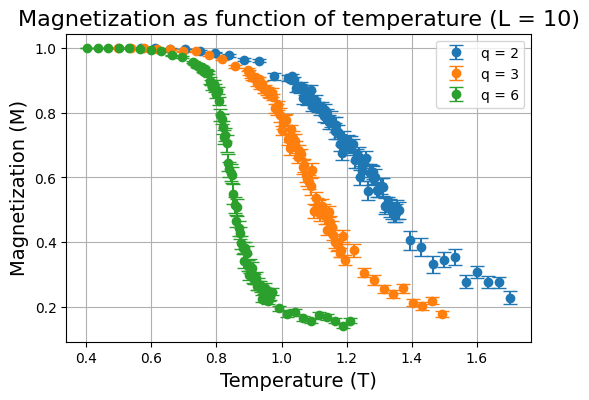

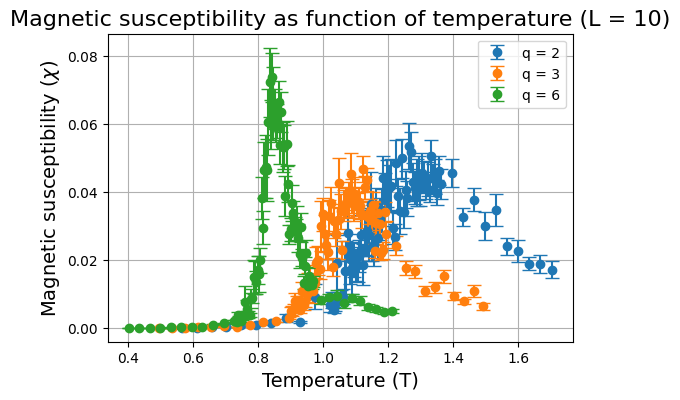

In [8]:
# plot the measurements in the file
with h5py.File('full_measurements.hdf5','r') as f:
    temperatures = f["temperatures"][()]
    magnetizations = f["magnetizations"][()]
    magnetization_errors = f["magnetization_errors"][()]
    for index_L, L in enumerate(Ls):
        plt.figure(figsize=(6, 4))
        plt.xlabel("Temperature (T)", fontsize=14)
        plt.ylabel("Magnetization (M)", fontsize=14)
        plt.title(f"Magnetization as function of temperature (L = {L})", fontsize=16)
        plt.grid(True)
        for index_q, q in enumerate(qs):
            temps = temperatures[index_q]
            mags = magnetizations[index_L, index_q]
            errors = magnetization_errors[index_L, index_q]
            plt.errorbar(temps, mags, yerr=errors, fmt='o', label=f"q = {q}", capsize=5)
        plt.legend()
        plt.show()

    susceptibilities = f["susceptibilities"][()]
    susceptibility_errors = f["susceptibility_errors"][()]
    for index_L, L in enumerate(Ls):
        plt.figure(figsize=(6, 4))
        plt.xlabel("Temperature (T)", fontsize=14)
        plt.ylabel("Magnetic susceptibility ($\chi$)", fontsize=14)
        plt.title(f"Magnetic susceptibility as function of temperature (L = {L})", fontsize=16)
        plt.grid(True)
        for index_q, q in enumerate(qs):
            temps = temperatures[index_q]
            suscs = susceptibilities[index_L, index_q]
            errors = susceptibility_errors[index_L, index_q]
            plt.errorbar(temps, suscs, yerr=errors, fmt='o', label=f"q = {q}", capsize=5)
        plt.legend()
        plt.show()
    

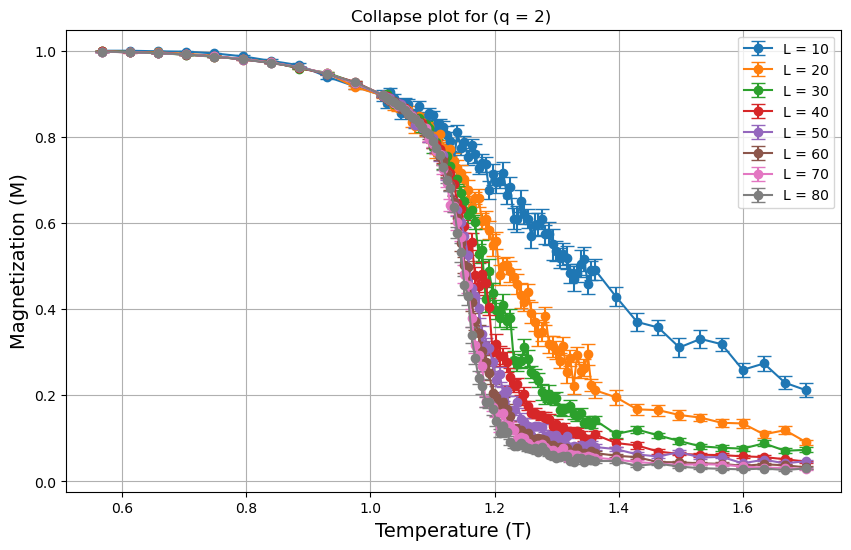

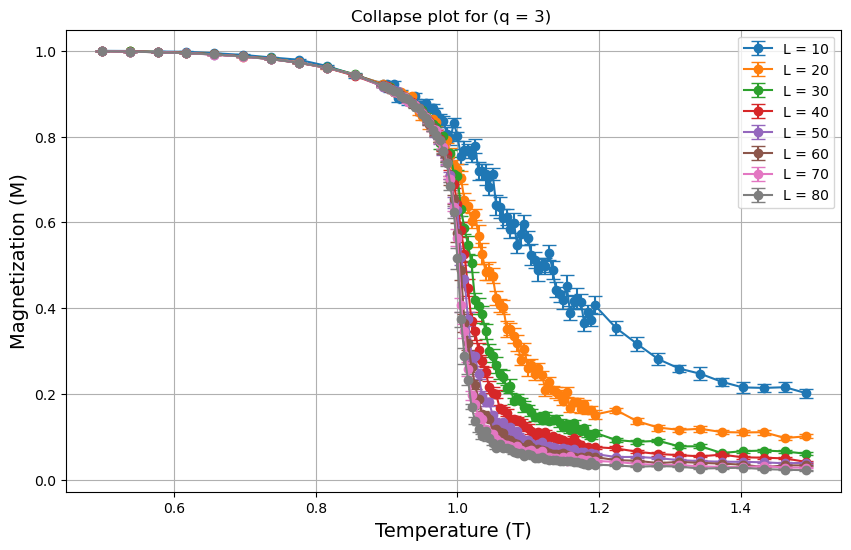

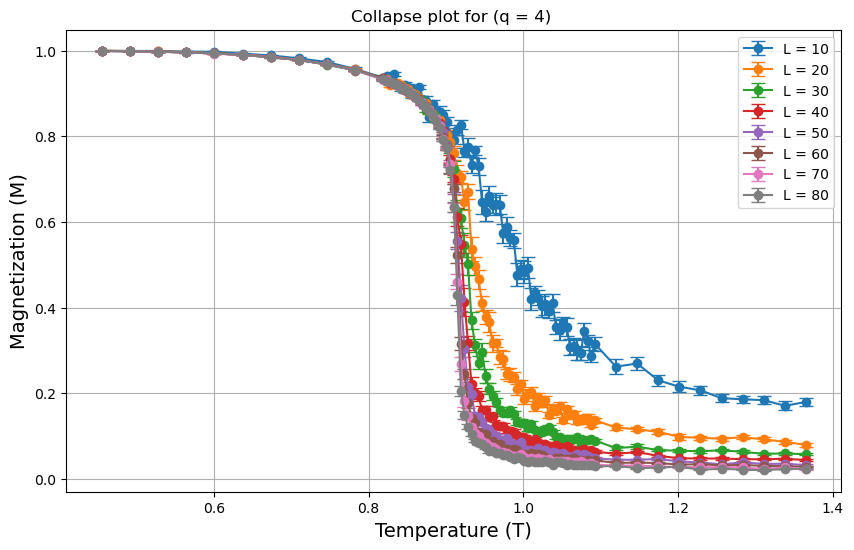

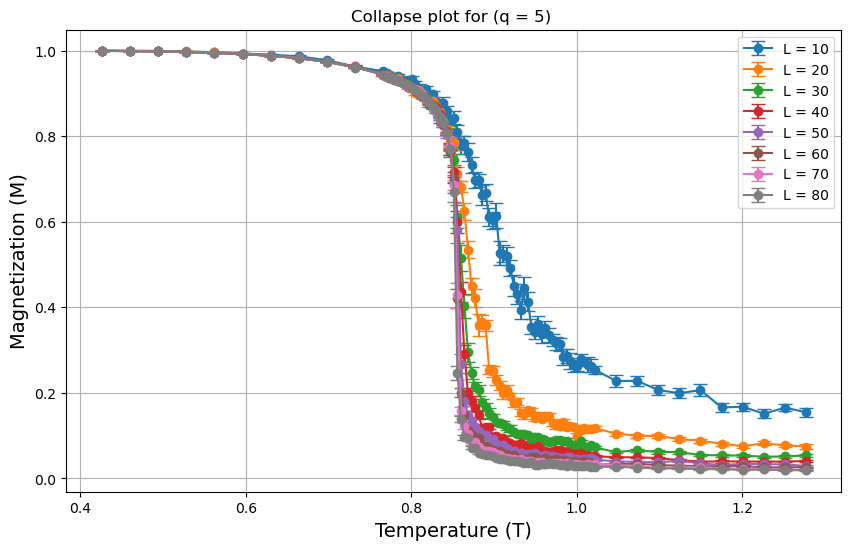

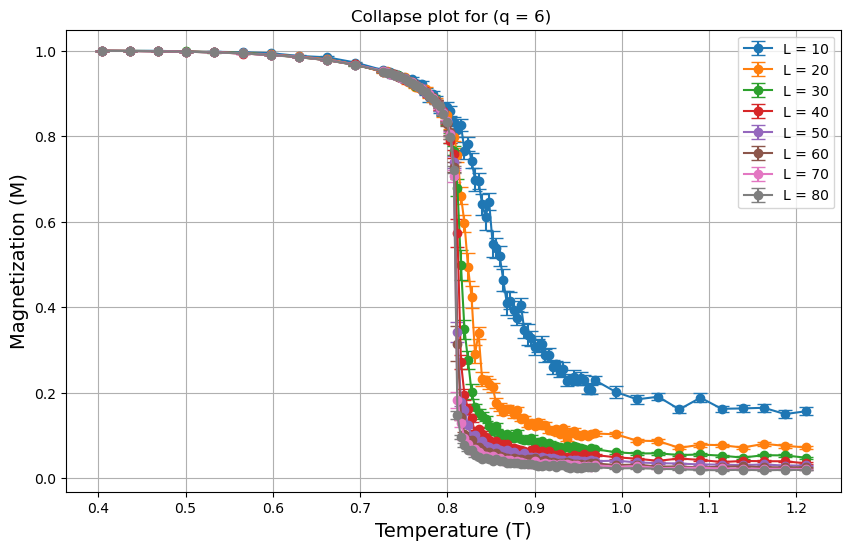

In [32]:
with h5py.File('full_measurements.hdf5', 'r') as f:
    temperatures = f["temperatures"][()]               
    magnetizations = f["magnetizations"][()]           
    magnetization_errors = f["magnetization_errors"][()]  


Ls =  [10,20, 30, 40, 50, 60, 70, 80]  
qs = [2, 3, 4, 5, 6]                   

# Create collapse plots for every q
for index_q, q in enumerate(qs):
    plt.figure(figsize=(10, 6))
    
   
    for index_L, L in enumerate(Ls):

        temps = temperatures[index_q]  
        mags = magnetizations[index_L, index_q]  
        errors = magnetization_errors[index_L, index_q]  
        plt.errorbar(temps, mags, yerr=errors, fmt='o-', label=f"L = {L}", capsize=5)

    plt.xlabel("Temperature (T)", fontsize=14)
    plt.ylabel("Magnetization (M)", fontsize=14)
    plt.title(f"Collapse plot for (q = {q}) ")
    plt.legend()
    plt.grid(True)
    plt.show()


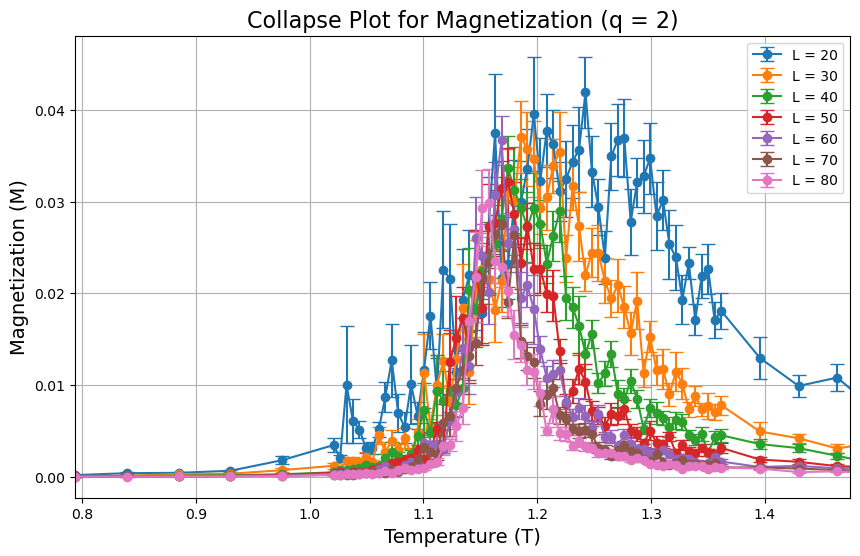

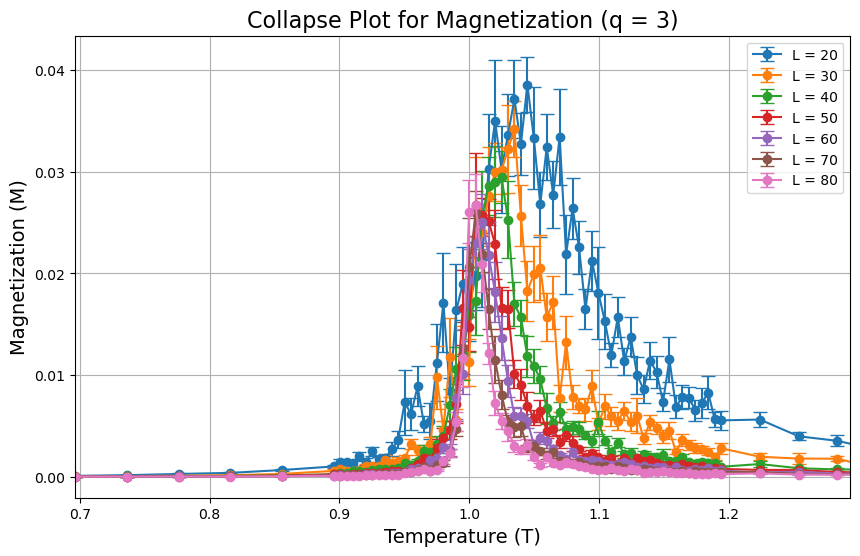

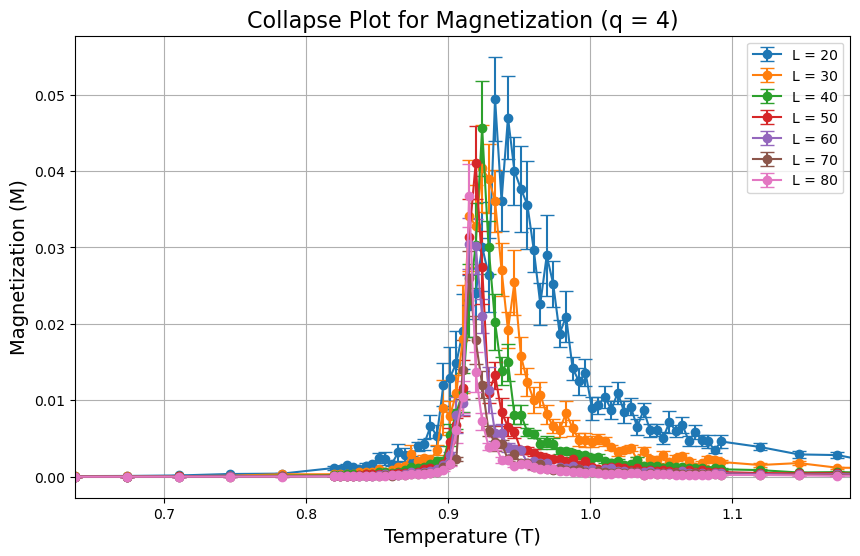

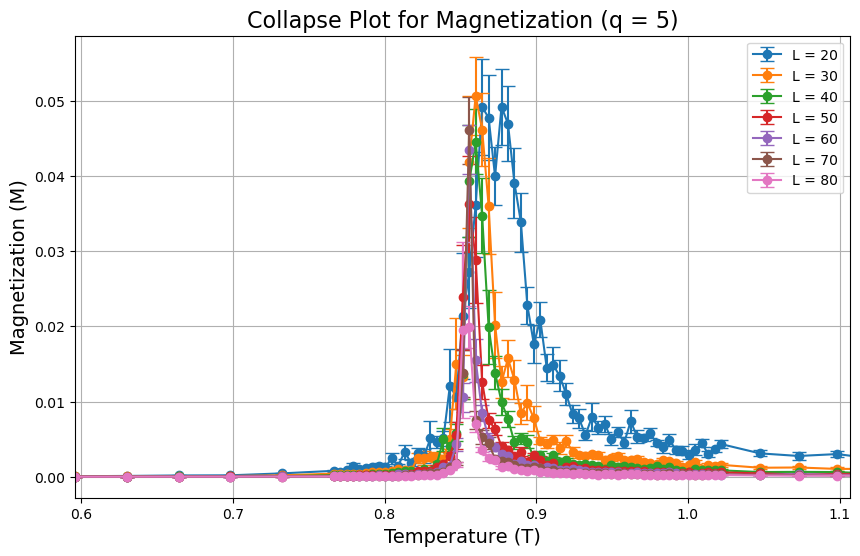

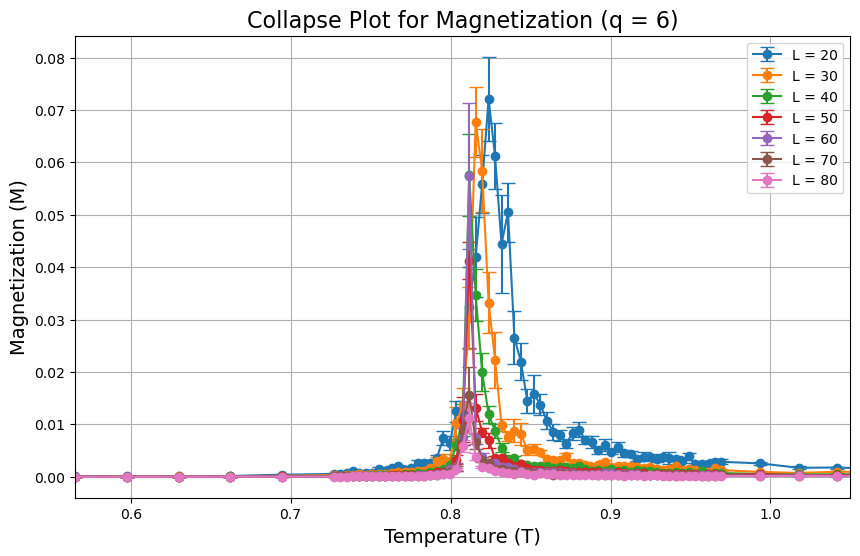

In [9]:
with h5py.File('full_measurements.hdf5', 'r') as f:
    temperatures = f["temperatures"][()]              
    susceptibilities = f["susceptibilities"][()]
    susceptibility_errors = f["susceptibility_errors"][()]

Ls =  [10,20, 30, 40, 50, 60, 70, 80] 
qs = [2, 3, 4, 5, 6]  
J = 1

for index_q, q in enumerate(qs):
    plt.figure(figsize=(10, 6))

    for index_L, L in enumerate(Ls):
        if L == 10:  # Skip L = 10 to reduce noise
            continue
        
        temps = temperatures[index_q]  
        sus =susceptibilities[index_L, index_q] 
        sus_errors =susceptibility_errors[index_L, index_q]  

        
        plt.errorbar(temps, sus, yerr=sus_errors, fmt='o-', label=f"L = {L}", capsize=5)
    T_c = calculate_critical_temperature(J , q, k_B=1.0)
   
    plt.xlabel("Temperature (T)", fontsize=14)
    plt.ylabel("Magnetization (M)", fontsize=14)
    plt.title(f"Collapse Plot for Magnetization (q = {q})", fontsize=16)
    plt.legend()
    ax = plt.gca()
    ax.set_xlim(0.7*T_c, 1.3*T_c)

    plt.grid(True)
    plt.show()


Final Critical Temperature for q = 2, L = 80: Tc = 1.169 ± 0.00195
Final Critical Temperature for q = 3, L = 80: Tc = 1.011 ± 0.00075
Final Critical Temperature for q = 4, L = 80: Tc = 0.919 ± 0.00062
Final Critical Temperature for q = 5, L = 80: Tc = 0.856 ± 0.00033
Final Critical Temperature for q = 6, L = 80: Tc = 0.812 ± 0.00017


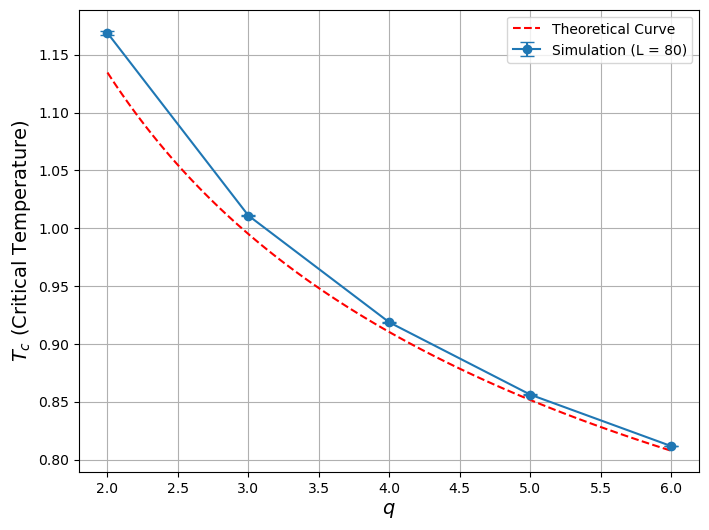

In [20]:
def gaussian(x, A, mu, sigma):
    """
    Gaussian function.
    """
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

def find_critical_temperature_gaussian_with_error(temps, susceptibilities):
    """
    Find the critical temperature and its error by fitting a Gaussian to the susceptibility peak.
    """
    max_index = np.argmax(susceptibilities)  
    peak_temp = temps[max_index]
    
    
    fit_range = 7  
    lower = max(0, max_index - fit_range)
    upper = min(len(temps), max_index + fit_range + 1)
    
    temps_fit = temps[lower:upper]
    suscept_fit = susceptibilities[lower:upper]
    
    A_init = np.max(suscept_fit) 
    mu_init = peak_temp           
    sigma_init = 0.05            
    

    popt, pcov = curve_fit(gaussian, temps_fit, suscept_fit, p0=[A_init, mu_init, sigma_init], maxfev=10000)
    A, mu, sigma = popt
    
    Tc_error = np.sqrt(pcov[1, 1])  

    return mu, Tc_error, popt, lower, upper


Tc_susceptibility_results = []
mc_critical_temp = []
mc_critical_temp_errors = []

L = 80
index_L = Ls.index(L) 

for index_q, q in enumerate(qs):

    temps = temperatures[index_q]
    suscept = susceptibilities[index_L, index_q]

    Tc, Tc_error, fit_params, lower, upper = find_critical_temperature_gaussian_with_error(temps, suscept)

    mc_critical_temp.append(Tc)
    mc_critical_temp_errors.append(Tc_error)

    Tc_susceptibility_results.append((q, Tc, Tc_error))

    print(f"Final Critical Temperature for q = {q}, L = {L}: Tc = {Tc:.3f} ± {Tc_error:.5f}")


q_theory = np.linspace(2, 6, 100)
Tc_theory = 1 / np.log(1 + np.sqrt(q_theory))


plt.figure(figsize=(8, 6))
plt.errorbar(qs, mc_critical_temp, yerr=mc_critical_temp_errors, fmt='o-', capsize=5, label="Simulation (L = 80)")
plt.plot(q_theory, Tc_theory, 'r--', label="Theoretical Curve")
plt.xlabel(r"$q$ ", fontsize=14)
plt.ylabel(r"$T_c$ (Critical Temperature)", fontsize=14)

plt.grid(True)
plt.legend()
plt.show()


The critical temperatures and Critical exponets should have been stored in full_measurements.hdf5 so the data analysis can be  reproducible. Unfortunetely we oversee it.

Found d_H for q = 2: 1.344


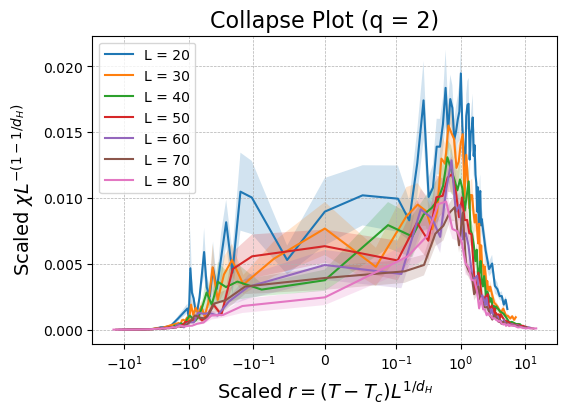

Found d_H for q = 3: 0.965


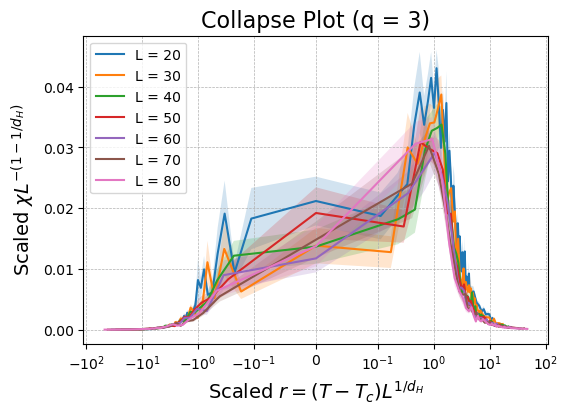

Found d_H for q = 4: 0.817


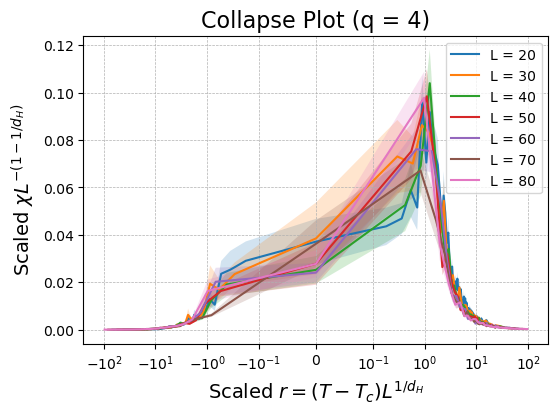

Found d_H for q = 5: 1.617


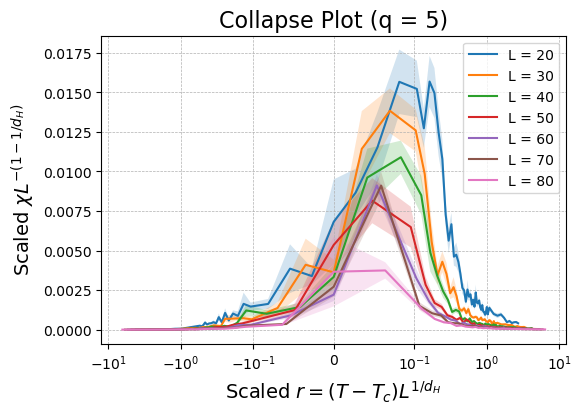

Found d_H for q = 6: 0.800


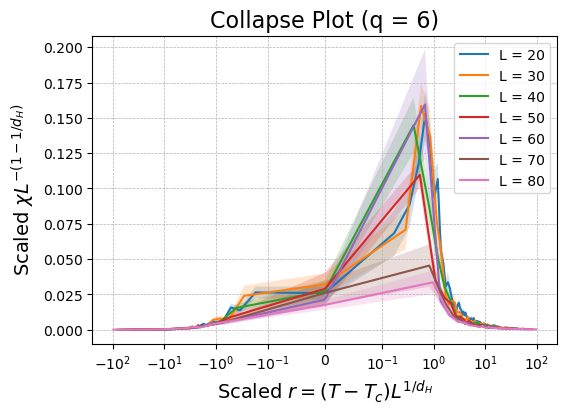

d_H values for all q:
q = 2, d_H = 1.344
q = 3, d_H = 0.965
q = 4, d_H = 0.817
q = 5, d_H = 1.617
q = 6, d_H = 0.800


In [16]:
def compute_rescaled_data(Tc, d_H, Ls, temperatures, susceptibilities):
    """
    Compute the rescaled data for given d_H.
    """
    rescaled_temps = []
    rescaled_suscs = []
    for index_L, L in enumerate(Ls):
        temps = np.array(temperatures)
        suscs = np.array(susceptibilities[index_L])

        temps = temps.flatten()
        suscs = suscs.flatten()

        scaled_temps = (temps - Tc) * L**(1 / d_H)
        scaled_suscs = suscs * L**(-(1 - 1 / d_H))
        
        rescaled_temps.append(scaled_temps)
        rescaled_suscs.append(scaled_suscs)
    
    return rescaled_temps, rescaled_suscs
    
def collapse_error(d_H, Tc, Ls, temperatures, susceptibilities):
    """
    Compute the misalignment error for a given d_H.
    The error is the variance of the rescaled susceptibility curves at overlapping scaled temperatures.
    """
    rescaled_temps, rescaled_suscs = compute_rescaled_data(Tc, d_H, Ls, temperatures, susceptibilities)

    all_rescaled_temps = np.concatenate(rescaled_temps)
    common_x = np.linspace(all_rescaled_temps.min(), all_rescaled_temps.max(), 100)

    interpolated_suscs = []
    for x, y in zip(rescaled_temps, rescaled_suscs):
        x = np.array(x).flatten()  # Ensure x is 1D
        y = np.array(y).flatten()  # Ensure y is 1D
        interpolated_suscs.append(np.interp(common_x, x, y))
    
    interpolated_suscs = np.array(interpolated_suscs)
    error = np.mean(np.var(interpolated_suscs, axis=0))
    return error

def find_optimal_d_H(Tc, Ls, temperatures, susceptibilities, d_H_range=(0, 6)):
    """
    Optimize d_H to minimize collapse error.
    """
    result = minimize(lambda d_H: collapse_error(d_H[0], Tc, Ls, temperatures, susceptibilities),
                      x0=[0.8],  # Initial guess
                      bounds=[d_H_range])
    return result.x[0]

qs = [2,3,4,5,6]
Ls = [10,20,30,40,50,60,70,80]
J = 1.0
d_H =[]

with h5py.File('full_measurements.hdf5','r') as f:
    temperatures = f["temperatures"][()]
    magnetizations = f["magnetizations"][()]
    magnetization_errors = f["magnetization_errors"][()]
    susceptibilities = f["susceptibilities"][()]
    susceptibility_errors = f["susceptibility_errors"][()]

d_H_values = {}

for index_q, q in enumerate(qs):
    plt.figure(figsize=(6, 4))
    plt.xscale('symlog', linthresh=0.5)
    plt.grid(which="both", linestyle='--', linewidth=0.5)

    plt.xlabel(r"Scaled $r = (T - T_c)L^{1/d_H}$", fontsize=14)
    plt.ylabel(r"Scaled $\chi L^{-(1 - 1/d_H)}$", fontsize=14)
    plt.title(f"Collapse Plot (q = {q})", fontsize=16)
    plt.xscale('symlog', linthresh=0.1)
    plt.grid(True)

    T_C = calculate_critical_temperature(J, q)

    temps = temperatures[index_q]
    suscs = susceptibilities[:, index_q]

    d_H_current = find_optimal_d_H(T_C, Ls, temps, suscs)
    d_H_values[q] = d_H_current 
    print(f"Found d_H for q = {q}: {d_H_current:.3f}")

    for index_L, L in enumerate(Ls):
        if L == 10:
            continue
        temps = temperatures[index_q]
        suscs = susceptibilities[index_L, index_q]
        errors = susceptibility_errors[index_L, index_q]

        scaled_temps = (temps - T_C) * L**(1 / d_H_current)
        scaled_suscs = suscs * L**(-(1 - 1 / d_H_current))
        scaled_errors = errors * L**(-(1 - 1 / d_H_current))

        plt.plot(scaled_temps, scaled_suscs, label=f"L = {L}")  # Plot the line
        plt.fill_between(
            scaled_temps,
            scaled_suscs - scaled_errors,
            scaled_suscs + scaled_errors,
            alpha=0.2,
        ) 

    plt.legend()
    plt.show()

print("d_H values for all q:")
for q, d_H_value in d_H_values.items():
    print(f"q = {q}, d_H = {d_H_value:.3f}")


L = 30, T_c = 1.134592657106511, Chi = 0.0
Skipping L = 30 due to non-positive susceptibility: 0.0
L = 40, T_c = 1.134592657106511, Chi = 1.2029162501925767e-05
L = 50, T_c = 1.134592657106511, Chi = 9.343639095232744e-06
L = 60, T_c = 1.134592657106511, Chi = 4.210237394406327e-06
L = 70, T_c = 1.134592657106511, Chi = 3.059165002855188e-06
L = 80, T_c = 1.134592657106511, Chi = 1.6974903821290598e-06


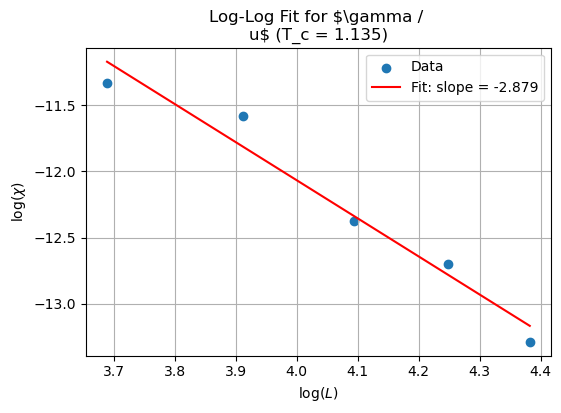

q = 2, d_H = 1.344, nu = -1.398, gamma = 4.026
L = 30, T_c = 0.994972861071817, Chi = 1.7716463555930228e-05
L = 40, T_c = 0.994972861071817, Chi = 5.8041359751544e-06
L = 50, T_c = 0.994972861071817, Chi = 5.2875356721789e-06
L = 60, T_c = 0.994972861071817, Chi = 1.7658139768254607e-06
L = 70, T_c = 0.994972861071817, Chi = 1.3145222917955271e-06
L = 80, T_c = 0.994972861071817, Chi = 1.3412716043154517e-06


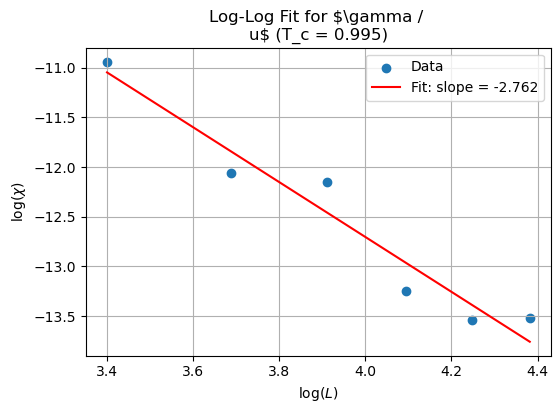

q = 3, d_H = 0.965, nu = -1.826, gamma = 5.044
L = 30, T_c = 0.9102392266268373, Chi = 2.1521913465419597e-06
L = 40, T_c = 0.9102392266268373, Chi = 1.2006909508026073e-06
L = 50, T_c = 0.9102392266268373, Chi = 1.8458632191206938e-06
L = 60, T_c = 0.9102392266268373, Chi = 1.297842834815461e-06
L = 70, T_c = 0.9102392266268373, Chi = 8.241810312515671e-07
L = 80, T_c = 0.9102392266268373, Chi = 6.575551859106227e-07


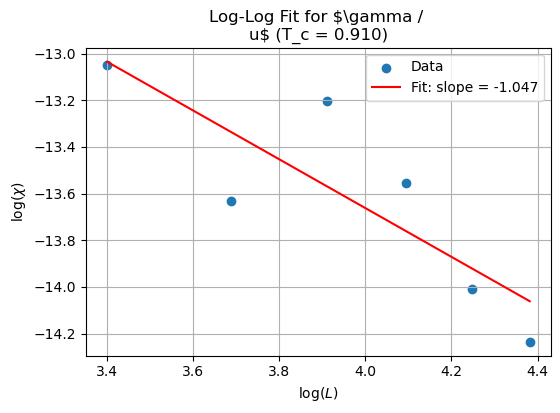

q = 4, d_H = 0.817, nu = -0.057, gamma = 0.060
L = 30, T_c = 0.8515283616124156, Chi = 7.590586032733013e-06
L = 40, T_c = 0.8515283616124156, Chi = 1.657735635657766e-06
L = 50, T_c = 0.8515283616124156, Chi = 3.143830473718447e-07
L = 60, T_c = 0.8515283616124156, Chi = 1.0026225995770538e-06
L = 70, T_c = 0.8515283616124156, Chi = 6.017269401638363e-07
L = 80, T_c = 0.8515283616124156, Chi = 5.278601595016378e-07


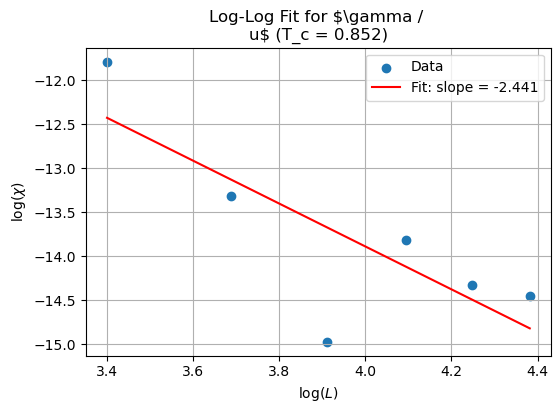

q = 5, d_H = 1.617, nu = -0.891, gamma = 2.175
L = 30, T_c = 0.8076068036045493, Chi = 6.033960404593887e-07
L = 40, T_c = 0.8076068036045493, Chi = 3.8143639683636376e-08
L = 50, T_c = 0.8076068036045493, Chi = 1.5345453922860204e-06
L = 60, T_c = 0.8076068036045493, Chi = 5.444376416027144e-07
L = 70, T_c = 0.8076068036045493, Chi = 3.9494908251308023e-07
L = 80, T_c = 0.8076068036045493, Chi = 2.9545240888635604e-07


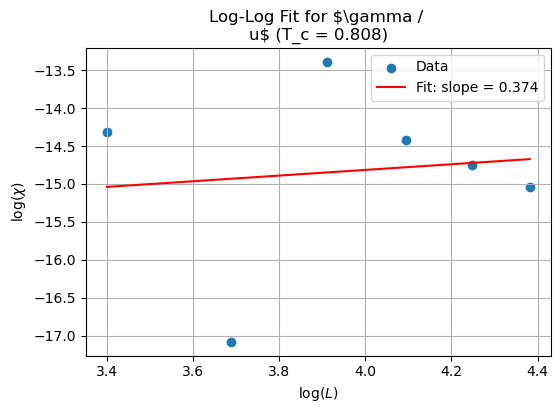

q = 6, d_H = 0.800, nu = 1.717, gamma = 0.642


In [28]:
def fit_gamma_nu(Tc, Ls, temperatures, susceptibilities):
    """
    Fit gamma/nu using susceptibility scaling at T_c.
    """
    chi_at_Tc = []  
    valid_Ls = []   

    for index_L, L in enumerate(Ls):
        temps = temperatures[index_L]  #
        suscs = susceptibilities[index_L]  
        chi_value = suscs[np.argmin(np.abs(temps - Tc))]
        chi_at_Tc.append(chi_value)
            
    log_L = np.log(L)
    log_chi = np.log(chi_at_Tc)
    slope, intercept, r_value, p_value, std_err = linregress(log_L, log_chi)

    plt.figure(figsize=(6, 4))
    plt.scatter(log_L, log_chi, label="Data")
    plt.plot(log_L, slope * log_L + intercept, label=f"Fit: slope = {slope:.3f}", color="red")
    plt.xlabel(r"$\log(L)$")
    plt.ylabel(r"$\log(\chi)$")
    plt.title(f"Log-Log Fit for $\gamma / \nu$ (T_c = {Tc:.3f})")
    plt.legend()
    plt.grid(True)
    plt.show()

    return slope  


def compute_nu_and_gamma(gamma_nu, d_H):
    """
    Compute nu and gamma using gamma/nu and d_H.
    """
    nu = (1 + gamma_nu) / d_H
    gamma = gamma_nu * nu
    return nu, gamma


qs = [2, 3, 4, 5, 6] 
Ls = [,20 30, 40, 50, 60, 70, 80]  
J = 1.0


with h5py.File('full_measurements.hdf5', 'r') as f:
    temperatures = f["temperatures"][()]
    susceptibilities = f["susceptibilities"][()]

for index_q, q in enumerate(qs):
    T_c = calculate_critical_temperature(J, q, k_B=1.0)
    T_c_error = mc_critical_temp_errors[index_q]
    d_H = d_H_values[q]  

    gamma_nu = fit_gamma_nu(T_c, Ls, temperatures[index_q], susceptibilities[:, index_q])
    nu, gamma = compute_nu_and_gamma(gamma_nu, d_H)
    print(f"q = {q}, d_H = {d_H:.3f}, nu = {nu:.3f}, gamma = {gamma:.3f}")

